In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from tqdm.auto import tqdm
import fitz
from spacy.lang.en import English # Create sentence barrier
from sentence_transformers import SentenceTransformer, util # The embedding model and the metric model to find meaning (similarity search between
# query meaning and the vector data in database from the the sentence chunks we embedded)
# Let's leave the LLM import later so we can know for certain which one we'll use
# Same with BytesAndBytesConfig to know if we need that for LLM, leave it for later, as our hardware isn't able to use flash attention 2
from newspaper import Article
import textwrap
import os
import re
from typing import Dict, List, Any

# Create and run a local RAG pipeline from scratch

### We'll embed and use any LLM models

#### What is RAG?

Rag is Retrieval Augmented Generation

The Goal Of Rag is take information and pass it into a LLM so it can generate outputs based on that information (especially to generate text transformer on the generate structure)

* **Retrieval detailed** - Find relevant information given a query e.b (we'll build Nutri-chat) a model that reads and trains it's neural network with those 1200 pages in the textbook about nutrution, so those model will serve as more a guide on what it learned from the data recieved on textbook, to provide relevant information on that subject. By giving a set of question that the model can respond if we train it to on general dialogue. (what are the macronutrients and what do they) 
* **Retrieval** - Find relevant info given a query (input data), e.g. "what are the macronutrients and what do they do>" -> retrieves passages of text related to the macronutrients from a nutrition textbook. (goes to layer it retrieved from all and matches strings with the number it encoded and relations on those text)
* **Augmented** - We want to take the relevant information and augment our input (prompt) "make of greater importantance and match with the best relating text pattern output and bring it to an LLM with that relevant information.
* **Generation detailed** - Take the first two steps R (retrieve input and text data relating towards input) and A (increase the importance of input with the relevant and most matched data retrieved making it augment the whole data) and pass them to an LLM for generative outputs. (to match the whole data importance to say in feedback this certain mode create "asko" the quotes are the augmentation if did from retrieving and pattern matching to input and the model from trained on dialogue to say proper general feedback to give this is this or that and know how to respond to question and understand mostly what's being typed completely)
Generation - Take the first two steps and pass tho an LLm for generative output

If you want to read where RAG came from, see the paper from Facebook AI - https://arxiv.org/abs/2005.11401

What was said: *"This work offers several positive societal benefits over previous work: the fact that it is more strongly grounded in real factual knowledge (in this case Wikipedia) makes it “hallucinate” less with generations that are more factual, and offers more control and interpretability. RAG could be employed in a wide variety of scenarios with direct benefit to society, for example by endowing it with a medical index and asking it open-domain questions on that topic, or by helping people be more effective at their jobs. With these advantages also come potential downsides: Wikipedia, or any potential external knowledge source, will probably never be entirely factual and completely devoid of bias. Since RAG can be employed as a language model, similar concerns as for GPT-2 [50] are valid here, although arguably to a lesser extent, including that it might be used to generate abuse, faked or misleading content in the news or on social media; to impersonate others; or to automate the production of spam/phishing content [54]. Advanced language models may also lead to the automation of various jobs in the coming decades [16]. In order to mitigate these risks, AI systems could be employed to fight against misleading content and automated spam/phishing."*

This is better for specific questions on topics relating to a subject, in comparison with gpt is good for general as it captures a vast amount of text than rather several to retrieve and remember them or let's for better "use them", that's why GPT gives very general answer due to it's model capability, however RAG uses a long range dependency like GPT but it's able to retrive more precise and detailed information that's right and not general to what's being asked because it take a large corpus of text, GPT doesn't have a built-in mechanism for retrieving specific information for a corpus.

Diablo GPT has more dialogue generation or observes dialogue text that is able to respond more relevant information what's being asked on the context but not exact questions that are more detailed and exact to explain which to me is the whole point of AI for text to understand really deep and big topics like in doctors or engineers etc to understand information or even a user as a client, this removes even people out of this point but rather have model solve all of this which is a great approach incoming and start it up.

GPT is trained on tons of terabytes of internet text data

#### Why Rag

The main goal of Rag is to improve the generation of outputs of LLMs.

1. Prevent hallucinations - LLMs are incredibly good at generating good *looking* text, however, this text doesn't mean it's factual. Rage can help LLMs generate information based on relevant passages that are factual. (information stored somewhere to view what it sees by complete to know what your saying, GPT grabs bits and pieces what it sees and can't get you a straight answer to what you see)

Give specific topics to answer and if needing to bounce around on different topics match you can have GPT mix what your trying to understand in a RAG model

(GPT) can be very generic when asking questions like do this than this or this and those can help, but it doesn't tell you on things that can be a better solution to a deeper topic on understanding what it knows which is RAG can do to ask those questions.

2. Word with custom data - Many base LLMs are trained with internet-scale data. This means they have a fairly good understanding of language in general. ( they read internet data) which is filled with human text of conversations, behaviours, types of way of asking questions and answering

Augmentation would be to take passages from documents that you stored, put them into the query that's being asked. Than have a generative LLM to take those documents it has stored and retrieved from training data and stored data and format back to what it saw in a readable informative way for the user on query. This is the main point with **RAG**, it helps create specific responses based on specific documents

### What can RAG be used for?

* Customer support Q&A Chat - Treat your existing customer support documents as a resource and when a customer asks a question, you could have a retrieval system, retreive relevant documentation snippets and then have an LLM craft those snippets into an answer. Think of this as a "chatbot for your documentation".
* Email chain analysis - Let's say you're a large insurance company and you have chains and chains of emails of customer claims. You could use a Rag pipeline to find relevant information from those emails (retreive to store on database, model to view patterns) and then use an LLM to process that information into structured data. (Augmentation)
* Company internal documentation chat (to what you have in the inside)
* Textbook Q&A - Let's say you're a nutrition student and you've got a 1200 page textbook read, you could build RAG pipeline to go through the textbook and find relevant passages to teh questions you have.

Common theme: take your relevant documents to a query and process them with an LLM

The LLM is really a calculator for words. To match and understand them for all.

## Why local?

Fun,

privacy, speed and cost. Also way better expeirence and better user value. Pretrain the answer to whole text data, rather the model given to other companies and you fine tune it, by your own docs and needs but can't fully optimize on chat for generale small company to have on website to view what's around to best source to move to communicate and ask without browsing.As much but actually ask and it does everything it ask and actually communicate to view on site toc communicat on source the sources are placing the information, on website to rather have a bot that just can easily communicate practically to what the AI is doing to communicate with apps around through browser and also information on questions to answer on field to ask what i needs than rather in policy to need in help to solve than rather handle fast to more

* Privacy - If you have private ducomentation, maybe you don't want to send that to an API. You want to setup an LLM and run it on your own hardware.
* Speed - Whenever you use an API, you have to send some kind of data across the internet. Takes time. Running locally means we have instant access and not wait for transfers of data from the internet it needs retrieve.
* Cost - If you own your hardware, the cost is paid for your self and have more flexibility on the things your using in (the hardware to better software) But overtime, you don't have to keep paying API fees.
* No vendor lockin - If you run own software/hardware. If OpenAI/another large internet company shut down tomorrow, you can still run your business.

In [2]:
!nvidia-smi

Thu Apr 18 03:52:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti   WDDM  |   00000000:17:00.0  On |                  N/A |
| 24%   30C    P8             30W /  250W |    1025MiB /  11264MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### What we're going to build

* https://github.com/mrdbourke/simple-local-rag
* https://whimsical.com/simple-local-rag-workflow-39kToR3yNf7E8kY4sS2tjV

### Data preprocessing and embedding creation

Collection of documents (data): This can be any sort docement, pdf, txt, html, anything the model will read and retrieve

We can have this model read this pdf and learn pattern and augment relevant relations with data contained in it's models and easily view through locally on text. We can even do the same thing for the model to retrieve and augment data to the query from data on wikipedia.

We will grab 10 sentences on the document and preprocess the text into smaller documents containing these few sentences that are used in LLM as **context** (our retrieval passages, we'll pass to the LLM later)

Than embed those smaller chucnks of text (which means to convert that plane text and query into a numerical format for the model to calculate from sentence-transformers, these are options we can do with Hugging Face)

After embedding we can store it in Pytorch (torch.tensor) and it's fast on 100k+ embeddings. We can also store it on a database to use it later

Now in the visual graph above. You the user well ask a query "What are the macronutrients of a mango, How can i use them?" this query is than converted or embedded in the same format as the retrieved documents were to place it in the neural network to convert them into numeric representation.

When you ask GPT: "Hey, how much does an elephant weigh?" it will turn that query into numeric format, than it will quiz it's weights which are also numeric, and find out if it's seen the numbers of that query before in it's own database and what it was trained on, it will find similiar numbers to the query from the data it stored and give an output back to what it found in similiar by asking to in a dialogue way not just a clear answer but say as human this is what it does why and such etc. 

In the neural network it takes the embedding by parts and cache the result to find the relation within the database and repeat until it found through all data relating towards query (it stores the query inside the database and the documents it found with the same type of weights relating to the in it and can find relations which will make to augmenet other wise it will respond with dialogue that it coudn't find it.)

#### The retrieval part is when in finds the connect numeric data from it's own documents and data to the query through relations and weight size similiarly

It finds numeric representatoon in it's database to match what the query is saying. IN the same phase to it does the augmentation to combine the query and what it found relating towards each other

We take our question from the query and append the relevant passages to our text and we pass this text to a LLM


It grabs the numeric relation to the sentences related towards question in query and the model chosses which of the options in relation to query has more relations to it. Which has a numeric relation, same weight to the question, and this process is done by the Large Language Model (LLM), which of the options related to query is more closely related numerically to it by each word and seen output relation. Which of these sentences and processes match are related most to what's being asked, such as what where and why, the one that is get's processed and formatted into back dialogue text what they asked and place it out as ouput

it finds a page or paragraph relating towards problem:

context1: one of the articles or paragraphs it found relating towards numercially seen in the input or query
context2: another pargraph closely related to queries value and weight amount
context3: another paragrahph related towards query value and weight amount

based on which every has the closest numeric value to the query text numeric form is choosen for augmentation and ouput by the LLM

After augmenting the LLM generates output based on context related to query and it shows it in the UI program where the query is being sent, and we can get an answer to where that answer it made came from and actually see oruselves whether the model has been incorrect or the sources valid, which is great as it makes it more solid

The model will say the macronutrients are tied to this and here, this is where i got that information: on page 5 on the MacroNutrients sections, and also on page 22 on section bones, and page 53 on section eating etc it will give you the combination off results it found to give an answer from all areas on documents it did to augment process and place otput

## We're going to build NutriChat to "chat" with a textbook

textbook here can be anything such as customer relation docs, data analytics documents, culture docs, research paper docs, customer service docs etc

Specifically

1. Open a PDF ducment (you could use almost any PDF here or even a colleciton PDF's).
2. Format the text of the PDF textbook ready for an embedding model. (create chunks and get the sentences)
3. Embed all of the chunks of text in the textbook and turn into numerical representations (embedding) which we can store for later.
4. Build a retrieval system that uses vector search to find relevant chunk of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text. (reformats or decodes into back a string or the type of data the query was passed)
6. Generate an answer to a query based on the passages of the textbook with LLM.

All locally!

1. Steps 1-3: Document preprocessing and emedding creation.
2. Steps 4-6: Search and answer.

## 1. Document/text processing and embedding creation

Ingredients: 
* PDF document of choice (noteL this could be almost any kind of docment, I've just chosen to focus on PDFs for now).
* Embedding model of choice.

Steps:

1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later (embeddings will store on file for many years or until you lose your hard drive)

### Import PDF Document


* We've got a PDF, let's open it!

#### Let's use the PyMuPDF library

In [4]:
# We'll use a pdf ready and in a function we'll try to retreive the data inside including text, to be in right format, to get it all since it's a bit different in dealing with PDF

a token is a sub word piece of text, ex. "hello, world!" could be split into ["hello",","world","!"] a token can be a whole word.

part of a word or punctuation of characters. 1 token ~= 4 characters in english making 100 tokens if there is 75 words

Text gets broken into tokens before being passed to a LLM.

#### So a token is NOT a character but rather a word. 

It's a subpiece of the original word, so in tokenizing the word "tokenization" would look like "to" "ken" "iza" "tion" since where using a tokenizer that splits the original in 4 characters that it would place as a single token 

specifically 4 characters in a word is 1 token. Remember it's 'CHARACTERS' so it can be alphabetical or symbols such as [a, B, #, %, *. ^. /, ., z, q, `, -] etc

Conversly if you were using a tokenizer that treats each word as a single token, then the number of tokens is equivalent to the number of words

In our case if 100 tokens as 75 words than clearly we're sub splitting words so elephant can be "ele" "phant" it's splitting words into subword units, resulting in more tokens than the number of words, this a scenario used for subword tokenization, where words are broken down into smaller units to improve the models ability to handle rare words or out of vocabulary words such as slangs or sentences that don't connect grammicaly but can understand in general what there asking for importance.


Here is a great doc explaining Tokenizer in depth by openai - https://platform.openai.com/tokenizer

### This is the raw text that's placed in the query 

but when the words need to tokenized int he part of seperating them into sentencs to make chunks for models retrieval and comparison with data after the embeddment. The tokenization when it's converted into numbers look like this:

* This tokenization process is meant for the model to examine the text at a more granular level

These words and tokens are using a token subword scheme such as Byte Pair Encoding or WordPiece

### Why would we care about the token count?

Token count is important because:
1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens. (can't place all the text in our LLM and it would be computationally wastefull, since there is an amount of text that isn't use in all, that you need fo filter and sort)

For example an embedding model may have been trained to embed sequences of 384 tokens into numerical space. (sentence-transformers `all-mpnet-base-v2`)

we'll use hugging face sentence transformer - https://huggingface.co/sentence-transformers/all-mpnet-base-v2
and also from sbert.net sentence transformer - https://sbert.net/docs/pretrained_models.html

Some models in sentence transformer actually have a limit to the amount of tokens they can get, for example the `all-mpnet-base-v2` can only take about 384 max seqeunce token, anything more will get shrinked down making response unreliable if you need more spread out wide results

An embedding model will turn a string of text into a numeric representation to be useful for machine

As for LLM's, they can't accept an infinite tokens in their context window

You don't want to have the most tokens, but rather have the best token to gather from whole section

## Let's research and find all relevant data online for our database in RAG

Let's start with `site pages` and `PDF's` from our **data-processing notebook**

In [13]:
# Load CSV file from data processing that has the raw data formatted
df = pd.read_csv("./data-processing/indata-processing/whole_sitepages_pdf_text_df.csv")
data_dict = df.to_dict(orient="records")
df = pd.DataFrame(df)
data_dict = df.to_dict(orient="records")

In [14]:
df.describe().round(2)

,link_or_page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,2545.00,2545.00,2545.00,2545.00,2545.00
mean,73.32,4040.39,631.01,40.29,1010.10
std,137.05,2386.37,366.26,62.59,596.59
min,0.00,0.00,1.00,1.00,0.00
25%,4.00,2219.00,350.00,11.00,554.75
50%,12.00,3878.00,584.00,18.00,969.50
75%,47.00,5443.00,889.00,34.00,1360.75
max,566.00,13344.00,2273.00,1156.00,3336.00


### Let's keep our formatted data into a dictionary that we can manipulate it easier

We got our data on each key, let's add a sentenicer to create sentence barriers

**Let's add SpaCy sentencizer** In our main jupyter notebook now

In [15]:
# Add spacy sentencizer
# Let's do a sample to get how this works
nlp = English()

nlp.add_pipe('sentencizer') # sentencizer is meant to segment the text when nlp("text.") into a object making as sentences
doc = nlp("This is a sentence. This another. The last sentence.")
assert len(list(doc.sents)) == 3 # assert is like an if condition, if this isn't exactly 3 sentences than it would raise an AssertionError
# We want this condition because clearly we have 3 sentences but this is to make sure that sentencizer NLP is working to find sentences
list(doc.sents) # in this list contains each sentences, this efficient for our formatting and dictionary. In a page contains all the sentences to it
# but each sentences is seperated and indentified in our code by a NLP sentencizer
# the doc.sents will simple make the doc object that was done when we sent that sentence string to nlp and it turned it into an object
# really to process it than doc.sents will create barrier on only that doc object format that sentencizer understands

[This is a sentence., This another., The last sentence.]

### The sentencizer is working, let's make a function

Let's function both this sentencizer with the accuracte amount of total sentences and
make the chunks of 10 sentences in 1 function.

> Also let's allow only sentences containing more than 30 tokens, anything less will excluded

We are removing the less 30 tokens on the chunks because this is were we will process it into the embedding. If we minimized on sentences it wouldn't be clear to the total sentences as text creating is not fully fixed  (some sentences bigger than other) but in total 10 sentences should contain an expected amount of characters in total. In our case really doing it on the chunking process just makes it more practical as that's the area that will finally be embedded. So we make sure after embedding that each chunk contains more than 30 tokens.

Plus the NLP on sentencizer well sentencize even when it sees `1.` or `3.` since it ends in a period and has a space. That's why it's better after nlp and chunking to only allow > 30 size tokens on each batch

#### Let's see if our nlp sentencizing works as it should for all of them, than afterwords we can proceed to place them in a dict --> chunks

### Further text processing (splitting pages into sentences)

#### splitting pages into group of 10 sentences

Two ways to do this:
1. We've done this by splitting on `". "`.
2. We can do this with a NLP library such as spaCy https://spacy.io/usage and NLTK https://www.nltk.org/ (You need to preprocess text and prepare it for LLMs)


In [13]:
from spacy.lang.en import English

nlp = English()

# Let's add a sentencizer pipeline, see 
nlp.add_pipe("sentencizer")

# add a sentencizer model to combine what it sees on the vocab in improvement from similiar models and combines

# Create document instance as an example
doc = nlp("This is a sentence. This another sentence. I like elephants.")
assert len(list(doc.sents)) == 3

# print out our sentences split
list(doc.sents)



[This is a sentence., This another sentence., I like elephants.]

#### Let's see if our nlp sentencizing works as it should for all of them, than afterwords we can proceed to place them in a dict --> chunks

In [16]:
# function

def sentencizer_and_chunking(data_dict: list,
                             num_sents_per_chunk: int=10):
    """
    Sentencize your sentences, add them to dictionary with accurate total sentences,
    chunk each sentences into 10 per group, add to dict again with right labels,
    than exclude any chunks with less than 30 tokens.
    """

    # Let's make a list to contain all the seperated sentences for a sample
    # Make sure all text here is string when it identifies it, for some reason the nlp when seeing numbers can detect floats or ints even if they were
    # in dataframe into dict so convert tem here to str to be sure
    nlp = English()
    nlp.add_pipe('sentencizer')
    for i in data_dict:
        text = str(i['text'])
        doc = nlp(text)
        sentence = [str(sent) for sent in doc.sents]
        i['sentence'] = sentence
        i["page_sentence_count_spacy"] = len(i['sentence'])

        # Chunk sentences
        # Split the list
        # for each item in rane of 0 to the max length of items in sentence_list, iterate by a step of num_sents_per_chunk, than have it return
        # the sentence position that has 10
        sentence_list = i['sentence']
        split_sentence_list = [sentence_list[i:i + num_sents_per_chunk] for i in range(0, len(sentence_list), num_sents_per_chunk)]
        # Loop through the pages and split the sentences into chunks
        i["sentence_chunk"] = [chunk for chunk in split_sentence_list]
        i['num_chunks'] = len(i["sentence_chunk"])

    return data_dict

def chunks_and_tokenize(data_dict: list,
                        token_amount: int):
    """
    This will make a chunk_list filled of dictionaries, to make analyzes more practical.
    It will exclude a token amount to allow only a set minimum # tokens in our chunks
    """

    # Make chunk list(dict)
    pages_and_chunks = []
    for i in data_dict:
        for sentence_chunk in i['sentence_chunk']:
            chunk_dict = {}
            chunk_dict["link_or_page_number"] = i["link_or_page_number"]
            # Join sentences together as a paragpraph structure (as a chunk so it's just a single string than rather seperated in the sentence chunk all
            # together)
            joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
            joined_sentence_chunk = re.sub(r'\.([A-Z0-9])', r'. \1', joined_sentence_chunk) # For any full stopped characters
            chunk_dict["sentence_chunk"] = joined_sentence_chunk

            # Get stats for chunk dict
            chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
            chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")]) # Now it's seperated in the entire dictionary, that 
            # way calling each item is really each character before a space making it a word

            # Let's only allow 30 tokens or above
            chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4
            pages_and_chunks.append(chunk_dict)

    # Let's only allow 30 tokens above for each chunk
    df = pd.DataFrame(pages_and_chunks)
    pages_and_chunks_overmin_token_dict = df[df["chunk_token_count"] > token_amount].to_dict(orient="records")
    
    return pages_and_chunks, pages_and_chunks_overmin_token_dict

It will count 20 even if there was 15 sentences since it rounds

in this line of code: `sentence = [str(sent) for sent in doc.sents]` the doc.sents is to make the object nlp in sents barrier, once it does than each sentence inside that object will be make into string type and sentence is now the variable containing just the sentence for the page or link we're looking at

#### We can analyze after sentencizing and chunking, too see if everything was good

By seeing in dataframes but all of this after making sentences than chunks

In [17]:
sentences_and_chunks = sentencizer_and_chunking(data_dict=data_dict,
                                                num_sents_per_chunk=10)

In [18]:
chunk_token_dict, chunk_min_token = chunks_and_tokenize(data_dict=data_dict,
                                                        token_amount=30)

Let's analyze these chunks now

In [19]:
len(chunk_token_dict), len(chunk_min_token)

(10321, 10077)

#### Get the funtion grab the seperated sentences and add them to `data_dict` we're all those other keys are and get an accurate sentence count

or you can add them to the dataframe `df` if that is more practical, as another column filled with that sentence content, make it drop the last sentences with new ones. This is so that we can actually chunk our sentences by 10 since it's unpredictable to do this without seperating them with NLP

In [22]:
pages_sentences_and_chunks_df = pd.DataFrame(sentences_and_chunks)
# pages_and_sentences_df.head()
pages_sentences_and_chunks_df.describe().round(2)

,link_or_page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy,num_chunks
count,2545.00,2545.00,2545.00,2545.00,2545.00,2545.00,2545.00
mean,73.32,4040.39,631.01,40.29,1010.10,35.80,4.06
std,137.05,2386.37,366.26,62.59,596.59,46.43,4.64
min,0.00,0.00,1.00,1.00,0.00,1.00,1.00
25%,4.00,2219.00,350.00,11.00,554.75,11.00,2.00
50%,12.00,3878.00,584.00,18.00,969.50,18.00,2.00
75%,47.00,5443.00,889.00,34.00,1360.75,33.00,4.00
max,566.00,13344.00,2273.00,1156.00,3336.00,392.00,40.00


In [23]:
# pages_sentences_and_chunks_df[:2]
data_dict[2]['num_chunks']

2

In [24]:
data_dict[2]['page_sentence_count_spacy']

15

### Now let's make a seperate dictionary in the function called `chunk_dict`

showing relevant information for our data analysis (we can in future add each step process in other variables in a OOP) after that than we can any chunk that has less than 30 tokens

### This chunking is correctly because it needs to find each chunk per page

The total chunks can be really big

In [25]:
# chunk_token_dict[:2]

In [26]:
# data_dict[:5]

In [27]:
df = pd.DataFrame(chunk_token_dict)
df.describe().round(2)

,link_or_page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,10321.00,10321.00,10321.00,10321.00
mean,94.93,992.67,152.71,248.17
std,152.74,879.38,146.31,219.85
min,0.00,1.00,1.00,0.25
25%,7.00,467.00,68.00,116.75
50%,16.00,642.00,95.00,160.50
75%,96.00,1315.00,199.00,328.75
max,566.00,7536.00,1441.00,1884.00


### Our chunks have a low token count

Let's add a minimum amount to keep a worthy quantity of tokens

In [28]:
# for row in df[df["chunk_token_count"] <= 30].sample(10).iterrows():
#     print(f'Page Number or link: {row[1]["link_or_page_number"]} | Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

![image.png](attachment:63fc1183-b1ab-4aae-95d7-679d57e556b6.png)

### These tokens are not reliably, they give either titles, captions or headers

Let's change to only allow above 30 tokens

Let's place this inside our function

In [29]:
# chunk_min_token[:10]

### Great! Let's now finally embed our sentences into numeric form

using `all-mpnet-base-v2` is seen as the best in sbert.net

It has low memory size, A high embedding speed and semantic search. It's now the complete fastest in embed but all around it's better than the rest because there is another that has 1 digit above in speed for embedding but it takes long to cross semantic search and has a bigger size storage requirement which isn't worth it

So we'll stick to `all-mpnet-base-v2`

#### Let's create a function to just embed our data

We keep this step seperate if we needed to manipulate anything additionally in the future with just our function for the NLP and chunking process

In [30]:
# Let's use the sentence_transformers for the embedding
embedding_model = SentenceTransformer(model_name_or_path='all-mpnet-base-v2',
                                      device='cuda')

c:\Users\santi\Deep-Learning\rag\medical-rag\run-an-llm-from-scratch\gemma\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\santi\Deep-Learning\rag\medical-rag\run-an-llm-from-scratch\gemma\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [31]:
def embedding_data(chunk_data: list,
                   batch_size: int=10,
                   convert_to_tensors: bool=True):
    """
    Embeds the whole sentence_chunks inside the dictionary into
    vectors.
    """
    
    for i in chunk_data:
        i["embeddings"] = embedding_model.encode(i["sentence_chunk"])

    df = pd.DataFrame(chunk_data)
    df.to_csv("./chunks_tokenized.csv", index=False)
    # Let's batch them into 32 to make the processing faster
    # text_chunks = [i['sentence_chunk'] for i in chunk_min_token]

    # text_chunk_embeddings = embedding_model.encode(text_chunks,
    #                                                batch_size=batch_size,
    #                                                convert_to_tensor=True)
    return chunk_data

#### I tried the batching but it made no difference with no batching

So it's simplier to comment out the code doing that

In [35]:
text_chunk_embeddings = embedding_data(chunk_min_token)

Great we just added the embeddings to our dictionary on `chunk_min_token`

We can actually batch them to make the process faster

### Lets add the `text_chunk_embedding` inside our `chunk_min_token` dict

✅than after we will save it to a csv to save our embedded format vector data in the database

## Let's now load our csv embeddings (tokens officially) into a dataframe

In [32]:
# loaded chunks and tokens
df_embeds = pd.read_csv('./chunks_tokenized.csv')
df_embeds[:3]

,link_or_page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embeddings
0,0,1. Checkpoints Inhibitors: Checkpoint inhibito...,878,128,219.5,[ 7.50207156e-02 -6.30471781e-02 -2.76404526e-...
1,0,"Some drugs, known as apoptosis inducers, can t...",830,127,207.5,[ 2.01551374e-02 -1.88169186e-03 -3.07534169e-...
2,0,Senescence inducers target speciﬁc pathways in...,398,59,99.5,[ 4.52404656e-02 1.68271977e-02 -5.62751805e-...


## We have to convert the embeddings column in df into `tensors`

First we have grab each element in embeddings row and make into a numpy array first before making them into tensors

In [33]:
# convert to np array on embeddings

# Apply to each element in row (rows content) is what the apply(lamda) is doing. np already makes into array when you say it came from np.fromstring
# fromstring into np array
df_embeds["embeddings"] = df_embeds["embeddings"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# convert df into list[dict]
embeds_dict = df_embeds.to_dict(orient="records")

# convert into tensors
embeddings = torch.tensor(np.array(df_embeds["embeddings"].to_list()), dtype=torch.float32).to('cuda')

In [34]:
embeddings.shape

torch.Size([10077, 768])

This is standard dimension for the sentence transformer we got

We also placed this embeddings into a `list` so we can use it later when it comes to processing the whole rag pipeline

## Let's use the whole RAG this time to see if everything is working as expected

In [35]:
from time import perf_counter as timer

In [42]:
# # RAG
# query = "what treatments can be done when someone has breast cancer"

# # embed query
# query_embeddings = embedding_model.encode(query,
#                                           convert_to_tensor=True).to('cuda')

# # compare query embeddings with data embeddings using dot score
# start_time = timer()
# dot_scores = util.dot_score(a=query_embeddings, b=embeddings)[0]
# end_time = timer()

# # Get top5 scores
# scores, indices = torch.topk(dot_scores, k=5)

# print(f"Scores: {scores}")
# print(f"Indices: {indices}")

In [36]:
chunk_min_token[301]

{'link_or_page_number': 13,
 'sentence_chunk': 'Patients undergoing mastectomy may also need radiation if the tumor is large or there is lymph node involvement. Women undergoing mastectomy who elect breast reconstruction have several options, including the type of tissue or implant used to restore breast shape. Reconstruction may be performed at the time of mastectomy or later, but often requires more than one surgery. Depending on cancer stage, subtype, and sometimes other test results, such as tumor gene expression profiling (e.g., Oncotype DX), treatment may also involve chemotherapy (before and/or after surgery), hormone (anti-estrogen) therapy, targeted therapy, and/ or immunotherapy (e.g., immune checkpoint inhibitors). Survival: The 5- and 10-year relative survival rates are 91% and 85%, respectively, for invasive breast cancer overall, mostly because two-thirds of women are diagnosed with localized-stage disease. Despite progress over time, the 5-year survival rate is 10% lower

### Let's make the visualization of the output more appealing by applying functions

In [37]:
import textwrap

In [38]:
# Make a text wrapper

def text_wrapper(text):
    """
    Wraps the text that will pass here
    """

    clean_text = textwrap.fill(text, 80)

    print(clean_text)

### Let's make a function for the whole rag output

In [39]:
# Let's first get the embedding model
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device='cuda')

c:\Users\santi\Deep-Learning\rag\medical-rag\run-an-llm-from-scratch\gemma\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [40]:
# functionize

def rag_pipeline(query,
                 embedding_model,
                 embeddings,
                 device: str,
                 chunk_min_token: list):
    """
    Grabs a query and retrieve data all in passages, augments them, than it
    it outputs the top 5 relevant results regarding query's meaning using dot scores.
    """

    # Retrieval
    query_embeddings = embedding_model.encode(query, convert_to_tensor=True).to(device)

    # Augmentation
    dot_scores = util.dot_score(a=query_embeddings, b=embeddings)[0]

    # Output
    scores, indices = torch.topk(dot_scores, k=5)
    # counting = 0
    # for score, idx in zip(scores, indices):
    #     counting+=1
    #     clean_score = score.item()*100
    #     print(f"For the ({counting}) result has a score: {round(clean_score, 2)}%")
    #     print(f"On index: {idx}")
    #     print(f"Relevant Text:\n")
    #     print(f"{text_wrapper(chunk_min_token[idx]['sentence_chunk'])}\n")

    return scores, indices

In [41]:
import textwrap

def print_wrapper(text, wrap_length=80):
    """Wraps any text input and prints it out"""
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [42]:
from typing import Dict, List, Any

In [53]:
# Let's make a function that creates the whole output on top results
def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: List[Dict]=chunk_token_dict,
                                 n_resources_to_return: int=5):
   """
   Finds relevant passages given a query and print them out along with their scores
   """

   scores, indices = rag_pipeline(query=query,
                                  embedding_model=embedding_model,
                                  embeddings=embeddings,
                                  device='cuda',
                                  chunk_min_token=chunk_min_token)
   # Loop through zipped together scores and indices from torch.topk
   # scores = scores.tolist()[0]
   # indexes = indexes[1].tolist()[0]
   for score, idx in zip(scores, indices):
      print(f"Score: {score:.4f}")
      print("Text:")
      print_wrapper(pages_and_chunks[idx]["sentence_chunk"])
      print(f"Page Number: {pages_and_chunks[idx]['link_or_page_number']}")
      print(f"__Done__\n")
                                 

To view the score rounded we can't see it as a tensor but rather python float which as simple as saying `score.item()`

In [54]:
# query = "How does a stroke happen?"
# rag_pipeline(query=query,
#              embedding_model=embedding_model,
#              embeddings=embeddings,
#              device="cuda",
#              chunk_min_token=embeds_dict)

In [55]:
actual_query = "How does cholestoral effect heart disease"
# retrieve_relevant_resources(query=actual_query,
#                             embeddings=embeddings)
print_top_results_and_scores(query=actual_query,
                             embeddings=embeddings)

Score: 0.6482
Text:
Scoring Criteria for the DASH-Style Diet Score Table 5-2. This table shows the
scoring criteria for the Dietary Approaches to Stop Hypertension, or DASH-style
diet for the categories of fruits, vegetables, nuts and legumes, whole grains,
low-fat dairy, sodium, red and processed meats, and sweetened beverages.
Component Foods (NHANES 24-h recall) Scoring criteria Note Fruits All fruits and
fruit juices Quintile 1: 1 point Quintile 2: 2 points Quintile 3: 3 points
Quintile 4: 4 points Quintile 5: 5 points Higher score represents more ideal
intake Quintile 1 is lowest consumption, and quintile 5 is highest consumption
Vegetables All vegetables except potatoes and legumes Nuts and legumes Nuts and
peanut butter, dried beans, peas, tofu Whole grains Brown rice, dark breads,
cooked cereal, whole grain cereal, other grains, popcorn, wheat germ, bran Low-
fat dairy Skim milk, yogurt, cottage cheese Sodium Sum of sodium content of all
foods reported as consumed Quintile 1: 5

In [52]:
chunk_min_token[0]

{'link_or_page_number': 0,
 'sentence_chunk': '1. Checkpoints Inhibitors: Checkpoint inhibitors are drugs that target molecules such as PD-1 or CTLA-4 on immune cells. These molecules act as brakes on the immune system, preventing it from attacking normal cells. By blocking these checkpoints, checkpoint inhibitors can "release the brakes" on the immune system, allowing it to recognize and attack cancer cells, weakening them. 2. Targeted Therapies: Targeted therapies are drugs that target speciﬁc molecules or pathways that are critical for cancer cell growth and survival. For example, tyrosine kinase inhibitors (TKIs) target enzymes called tyrosine kinases, which are involved in cell signaling pathways that promote cancer growth. By inhibiting these enzymes, targeted therapies can weaken cancer cells. 3. Apoptosis Inducers: Apoptosis is a process of programmed cell death that eliminates damaged or abnormal cells.',
 'chunk_char_count': 878,
 'chunk_word_count': 128,
 'chunk_token_count'

#### Great! We have made the RAG Pipeline

## Functionizing our semantic search

input a query and you get a response from the augmentation that will be sent back to the query

let's put all of the steps from above for semantic search into a function, so we can repeat the workflow

if this notebook wasn't here we'd just have a python file that has the helper functions, import pdf and does all text chunks, embedding and search step by step, that's the point of this project to make all into a function, so it's deployable for an app

## Getting an LLM for local generation

This process can also work with an LLM API

LLM - Large Language Model

LLMs are constantly being updated so experiment often with news one that be better with previous

Since we want to run it locally we need to know how much compute power do we have, LLMs aren't small files so we should know this in advance. IF your looking for really big computation than you can use an API such as GPT-4 or Claude 3 but this has a trade off of waiting a response and having to pay that service to others, making you more dependable on them.

a 7 billion LLM size model is a normal size, requires 28gb VRAM GPU on a float32 processing (which are more complete numbers on the data to find relations complete)

7 billion parameter models, parameter here is the weight of the models, a small number that can learn relations and patterns on data. The more params the more the model has the opportunity to learn but the more compute cost since it has more weight to find relations which really on VRAM

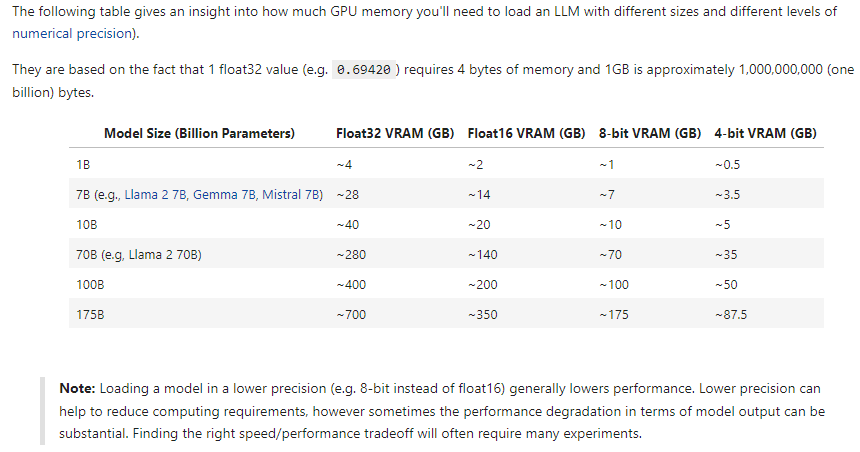

As you increase the number of bytes or numbers to relate the more you `numeric precision`

In computer science, in precision it's how many numbers are used to calculate a number. for ex.

In [56]:
torch.tensor([1]).dtype, torch.tensor([1.0]).dtype
# to get one it's represented in int64 which are sub numbers to represent that number of 1
# for 1.0 it's float32 to represent that number, which is the datatype /as we know but there has to be smaller numbers
# to represent that number

(torch.int64, torch.float32)

As we already get the data type on torch.tensor(), when half that precision we get less bytes so if we have 32 as 4 bytes, we half that 4 / 2 = 2 bytes and 16 bytes is 2 bytes, we than half it again, 2 / 2 = 1 byte which is grab by 8-bit for 1 bit and half that precision more, 1 / 2 = 0.5 bytes being 4-bit.

Less and less bytes means less precisions and less reliance but less compute, you need to best the results through to what you can see can give you the right amount and more

**BUT** this isn't a huge issue. Nowadays even having on a 4-bit vram, with the techiques done nowawadays gives pretty goo results, so it depends how you blend and best the results shown, the better is to blend a bit more bytes and still get a way better performance compared to cost what can be recieved

When there is so many parameters, when you remove some of the bytes that represent them over such a large scale, the degregations aren't bad but they are noticable several times, so it depends on how you can utilize it and what your doing with the data.

* The LLM you use is experimental and the data it takes up on your hardware will depend on the amount paraemters and percision you loaded it in, the performance of the model will depend on the amount of params it had as well as the precision that it computes in

float 32 isn't very common as it's very very big but more common is float16

### Good open source LLMs:
"These are contained normally 7 billion parameters"
* Hugging face
* Gemma
* Mistral AI
* Llama 2

Gemma seems right now to outperform by benchmark to other 2, so we'll use Gemma for this project

Take a big model make it smaller, accept the small performance degregation you're going to get

There is a model called The Bloke on hugging face, where it creates quantized (smaller version being a float16 Version and placing it to 4-bit VRAM) version of big models - https://huggingface.co/TheBloke

## Check local gpu computing memory

To see which LLM you can choose that your GPU can support

A Generative LLM

Goes from text input ---> generate text output

The LLM that you should use:

* How much hardware VRAM do we have?

#### Checking our local GPU memory

In [57]:
# Get GPU available memory
import torch
# Let's get memory in bytes
# position 0 for gpu and get it's total memory
# Our total memory in bytes
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
# Let's get the memory in gb
gpu_memory_gb = round(gpu_memory_bytes / (2**30)) # 2 ** 30 = 1,073.7418 Million bytes = 1 gb
print(f"Our GPU contains {gpu_memory_gb} gb of memory")

Our GPU contains 11 gb of memory


#### However that isn't the amount of free space we just the total

We should look at the free space

In [58]:
!nvidia-smi

Wed May 22 16:16:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti   WDDM  |   00000000:17:00.0  On |                  N/A |
| 25%   33C    P8             32W /  250W |    2039MiB /  11264MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

We have used 7.8gb of VRAM on the gpu which makes remaining, 2.8 gb we can use

* To download models and run locally from hugging face, you will need to sign in to hugging face CLI

**Do not enter `huggingface-cli login` inside the console**, do it in a seperate terminal

In [59]:
## huggingface-cli login

IT is instruction tune, meaning the base language model has been fine tuned to follow instructions.

Which is make me this and that, it will show you text and and value listed down, that's instruction tuning, similiar to the terminal, where you give it commands and responds to them. THis is good to access more direct and custom work to flow.

### Let's find our gpu memory that can work with gemma size models

In [60]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 11 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


### Loading an LLM locally With Gemma 2B in float 16 precision

We can load an LLM locally using Hugging face `transformers`.

The model we'll use on Nvidia 2080 Ti is Gemma 2B float16 VRAM

"*Less bits, the less space it will take up.*"
To get a model running locally we'll need several things:
1. A quantization config (optional) - a config on what precision to load the model in (e.g. 8bit, 4bit, etc)
2. A model id - this will give transformer which model/tokenizer to load (the type of tokenizer being used)
3. A tokenizer - this turns text into numbers to read for the LLM (NOTE: a tokenizer is different from an embedding model, a tokenizer will be specific to your LLM) The model id, hugging face makes it simple for transformers to pair the tokenizer and model you used
4. An LLM model - this will be what we use to generate text based on an input

> **NOTE:** There are many tips and tricks on loading/making LLMs work faster. One of the best ones is flash_attn (Flash Attention 2.) View they're github for more info - https://github.com/Dao-AILab/flash-attention
>> Flash attention is a self attention mechanism where it gets the input sequence tokens and groups them up into several groups to focus on attention on each group with several tokens rather than each token at a time which would increase computational cost, The Flash Attention provides a lower computation which would make it for more efficient on long text queries so the model can process. **The only problem:** is that this is right now 04/2024 only available for more recent bigger GPU such as Ampere, Ada, Hopper GPUS (e.g., A100, RTX 3090, RTX 4090, H100). Support for Turing GPUs (T4, RTX 2080) is coming soon, please use FlashAttention 1.x for Turing GPUs for now than flash attention 2
>> You can view your compute capability here - https://developer.nvidia.com/cuda-gpus

* We are not going to use quantization config

In [61]:
import torch
# Auto Tokenizer will create or tokizer automatically and AutoMOdelForCausualLM is to create a auto LM which is causal
# Casual is also a gnerative LM, based on the models ability to generate output based on early input sequences,
# such as the next token is generated based on the input tokens for before, it relies entirely on the past tokens sequence
# and action to make the next token, they must carry a chain link

# The Causal model predicts the next token in a sequence based on the previous tokens in the sequence during training and generation
# This process is a self attention mechanism, where next tokens are generated on links and relations on previous tokens sequences


from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_available 

# 1. Create a quantization config
# NOTE: requires !pip install bitsandbytes accelerate
 # Develops better on bits and bytes feature
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True, # load model in 4-bit
                                         bnb_4bit_compute_dtype=torch.float16) # compute in float 16 precision, a bit weird but it seems to work, find out more with your research

#  Bonus: flash attention 1 = faster attention mechanism
#  Flash Attention 2 requires a GPU with a compute capabilitiy score of 8.0+ as explained on markdown above
# Our GPU compute score is 7.5 as Nvidia RTX 2080 Ti
if (is_flash_attn_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_1"
else:
    attn_implementation = "sdpa" # scaled dot product attention, it's fast because on pytorch they have used
    # scaled dot product attention for flashAttention-v2 but it works for flash_attention_1

# 2. Pick model we should use (Gemma 2B-it)
model_id = model_id

# 3. Instantiate tokenizer (turns text into tokens)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# Instantiate the model
# there is a lot more parameters in here that you can try and tweak so try them out with several other biases
# to get more direct and wanted model for your project
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config,
                                                 low_cpu_mem_usage=False, # Use as much memory as we can
                                                 attn_implementation=attn_implementation)

# IF we have set a config, it will take care of the device placement automatically, that's part of the biteandbytes config
# and huggings face accelerate

# if we're not using this config than send the model (LLM model) to the GPU
# if not use_quantization_config:
#     llm_model.to("cuda")

Using `is_flash_attn_available` is deprecated and will be removed in v4.38. Please use `is_flash_attn_2_available` instead.
c:\Users\santi\Deep-Learning\rag\medical-rag\run-an-llm-from-scratch\gemma\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [62]:
print(f"Using attention implementation: {attn_implementation}")

Using attention implementation: sdpa


* If you load a big model and don't have enough GPU space it will offload it to CPU but we want to use as much memory for our GPU

If your downloading for the first time gemma, it would take awhile to load. Depending on internet connection

In [63]:
torch.cuda.get_device_capability(0) # our device capability can be found on torch

(7, 5)

In [64]:
# Let's check our remaining space of GPU memory
!nvidia-smi

Wed May 22 16:16:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti   WDDM  |   00000000:17:00.0  On |                  N/A |
| 25%   33C    P8             32W /  250W |    3700MiB /  11264MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [65]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
     

In [66]:
def get_model_num_params(model: torch.nn.Module):
    # Sum the number of params in model parameters
    # Sum the whole thing on different elements using a list []
    # amount of elements in params being every params themselves to get in param.num() as numbers in total
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

1515268096

It has 1.5 billion parameters in the LLM model

In [67]:
# How you can get the memory numbers for the different gemma sizes (2B, 7B, 10B) etc
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    # nelement() is the number of elements in the parameter
    #element_size() returns the numbers amount of elements contained in parameter which is dimensions and amount
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    # Let's do the same for the memoru buffers
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate model sizes
    # how much the model is taking up memory in our device
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2) # conversion to megabytes with bytes
    model_mem_gb = model_mem_bytes / (1024**3) # conversion to gigabytes with bytes

    return {"model_mem_bytes": model_mem_bytes, 
            "model_mem_mb": round(model_mem_mb, 2), 
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 2106740736, 'model_mem_mb': 2009.14, 'model_mem_gb': 1.96}

We got the size of our model
 
To load Gemma 2B float16 we need a minimum of 4.73 gb of VRAM on our GPU. However, due to the calculations that take place in the forward pass (which is when we pass input text to our model to process), we need closer to 8 gb

Loading our LLM model is one thing which takes up space but to have model process input text takes up more memory, in my case it's 8gb which we don't have

Even fitting a v100 gpu to a Gemma 7B-it on float16 would barely just fit for the LLM model and can't process as storage the input text that's will pass in model

### Generate text with our LLM

* Note: some models have been trained/tuned to generate text with a specific template in mind

Because `gemma-7b-it` has been trained in an instruction-tuned manner, we should follow the instruction template for the best results, similiar to when using chat gpt you don't have to format your text in a certain way for the model to understand since they fine tuned it to understand it that way. So the training process is what determines it's bias to understand text through a model, It's best if we get a model in the future (an LLM model) that isn't limited to some command intructions like which isn't scalable to retrieve information within it's data and augmentation rather we should have a model to understand general complex human text than some robot command.

We'll do that for another project, for now since we're using this the first time let's just follow the same template gemma was built on

Though the instructions are general, it doesn't do well with general feedback on questions and related depth about relations on what was discussed to understand what's being said more. instructions are more do this and that or when this rather if you ask things the amount of x goes into y, why was there another point, you said in z it effects that point, it can move to another area.. The model here wouldn't understand well because your giving it multi amounts of questions and relations not at least relevant now but will in the future regarding these more human and understand process of questions, to model the human not the machine as just intstruction

In [71]:
# Generate text on LLM with local
# input_text = "What are the macronutrients, and what roles do they play in the human body"
#  This will generation without retrieval 
# Our model is trained on internet text but it's recieving a retrieval from our data base through on dialogue as
# natural langure to understand something, rather the database can be the direct answer it grabs, but the generation
# on text to give it tell you this process will need this, wiht what we discussed it would need this and because your looking
# to advance that other part these other nutrients would provide more effets that can lead to a effect on making what
# you want so try those parts.. This sort of dialogue which is factual informative as it grabbed in ourcase a pbunch of
# the fact data it retreived on query and found relevant relations to it's passages and outputted it out, the large language model
# is what's responsible of wrapping the augmentation on what it found relation to the text to know use it's understand
# more of human explanation and logically forward thinking a question as they know intuitively that if one plays on another thing
# than another it would lead to a result similiar. MOstly the LLM wraps the text isntead of just pasting straight what i grabbed
# from the textbook, but really wrap these facts with explain your text can help with function, these effects lead to another part
# it may be scalable, you can view this it will help on more relieve and can generate a place portion on another text. 
# TO understand

### Let's format our input text into a tokenized prompt template for LLM

### Let's make the prompt to ask the LLM model directly a question without RAG

In [68]:
%%time

question = input("")

def gemma(input_text: str,
          tokenize=False,
          add_generation_prompt=True,
          max_new_tokens=256):
    """
    Gemma-2b-it LLM model, already contains tokenization and conversion process. All you pass is the question.
    """

    # Reformat prompt into technique
    input_text += ", keep your explanation complete, i don't want sentences that weren't completed."
    
    # Template
    dialogue_template = [{"role": "user",
                          "content": input_text}]
    
    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=tokenize,
                                           add_generation_prompt=add_generation_prompt) # generation prompt

    # TOKENIZATION
    input_ids = tokenizer(prompt,
                      return_tensors="pt").to("cuda")

    # llM generate and ouput with input_ids
    output_token = llm_model.generate(**input_ids,
                                      max_new_tokens=max_new_tokens)

    # Convert ouput_token into texy
    output_text = tokenizer.decode(output_token[0])

    print(f"Model output (decoded):\n{output_text}\n")

gemma(input_text=question)

c:\Users\santi\Deep-Learning\rag\medical-rag\run-an-llm-from-scratch\gemma\venv\Lib\site-packages\transformers\models\gemma\modeling_gemma.py:561: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Model output (decoded):
<bos><bos><start_of_turn>user
how does cancer grow?, keep your explanation complete, i don't want sentences that weren't completed.<end_of_turn>
<start_of_turn>model
Cancer cells are abnormal cells that have the ability to grow and spread to other parts of the body. They do this by:

**1. Mutation:** Cancer cells have an increased ability to mutate, meaning they can change their behavior and become more aggressive. This can be caused by various factors, including exposure to carcinogens (cancer-causing substances), genetic mutations, and certain environmental factors.

**2. Cell cycle errors:** Cancer cells often have genetic mutations that allow them to bypass normal cell cycle controls, leading to uncontrolled cell growth and division.

**3. Angiogenesis:** Cancer cells can form blood vessels to grow and spread to other parts of the body. This is essential for cancer cells to receive nutrients and oxygen.

**4. Invasion and metastasis:** Cancer cells can invad

In [69]:
input_text = "How does cancer cells mutate?"
print(f"Input text:\n {input_text}")

# Create prompt template for instruction-tuned model
# The template the model will recieve as input
dialogue_template = [{"role": "user",
                      "content": input_text}]
# In the tokenizer, it's able to convert dialogue_template we instiated into the actual right template (numerical for
# for our large language model) automatically

# Apply the chat template
# this will convert our dictionary with role and content into a list of tokens
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True) # generation prompt
print(f"\n Prompt (formatted):\n{prompt}")

Input text:
 How does cancer cells mutate?

 Prompt (formatted):
<bos><start_of_turn>user
How does cancer cells mutate?<end_of_turn>
<start_of_turn>model



Start of turn for user is the person asking the question on prompt and start of turn model now it's there place to grab that text on prompt and process into the Generative LLM

#### `Prompt` is the of the input given to a generative LLM

Prompt engineering is to structure a text-based input to a generative LLM in a specific way so the generative output is ideal for it's user on prompt

pad, end of sentence, beginning of sentence, unknown, start of turn, end of turn

### Tokenize the prompt

In [70]:
%%time
# Our input text was the input_text but we formatted it with the tokenizer as the right template for the prompt
# But we have't fully tokenized this template yet which we need to do, all the tokenizer did was move and organize
# the text and also instantiate a program that has it read to move from user into now the model, which the tokenization proces
# will find and tokenize simply this whole template into the exact same instruction but in a numerical format


# Tokenize the input text (turn it into numbers) and send it to the GPU
input_ids = tokenizer(prompt,
                      return_tensors="pt").to("cuda") # pt stands for pytorch, return tensors through pytorch and send it to the gpu, to compute
input_ids

CPU times: total: 0 ns
Wall time: 2 ms


{'input_ids': tensor([[     2,      2,    106,   1645,    108,   2299,   1721,   9198,   5999,
         167956, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

All these tensors are visible because there attention mask is 1 but you can mask out some the inputs via attention mask by setting several tensors in attention_mark to 0 but in our case we want to view the tensors completly, to then send it too the LLM model

We want our model to generate tokens based on the tensors on input

### An LLM outputs tokens **NOT** Text

We have to convert it to texts

Given input_id tokens from above, generate a maximum amount of 256 more

So we limited the amount of new tokens we can get, this likely is for efficiency on computing power for process in our model.

## Make the model find relations to our question in tensors to..

it's own training data and params to find relations between it's training and our tokenized prompt

In [71]:
%%time
# Generate outputs from local LLM
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)

print(f"Model output tokens: {outputs[0]}\n")

Model output tokens: tensor([     2,      2,    106,   1645,    108,   2299,   1721,   9198,   5999,
        167956, 235336,    107,    108,    106,   2516,    108,    688,  60013,
          5999,    791,   4282,  22154,    577, 167956, 235269,   3359,  66058,
           109,    688, 235274, 235265,  14349,   5855, 185261,  66058,    109,
        235287,   5231,  23281,  43009,  66058,   3766,   4559,    575,    573,
         11999,  10629,    798,  10396,   8700,   6887, 235269,   8133,    577,
          9198,   3505, 235265,    108, 235287,   5231,   7376,   1758,  55916,
         66058,   4213,   9198,   5999,  27033,   3437,  17058,    576,   3724,
         70753, 235269,   2183,   3588,  10225,  17058, 235265,    108, 235287,
          5231,  40048,    576,  24147, 156997,  19774,  66058, 185261,    575,
         24147, 156997,  19774,    798,  58473,   3027,  10501,  19084, 235269,
          8133,    577, 120669,   3027,   5115, 235265,    109,    688, 235284,
        235265, 197

**Our models did tokens in and tokens out**

### We placed input template in tokens, and the LLM response to tokens relations has outputted the response to input tokens in a token format but..

We want in back in text for our user

## Let's decode the tokens our model generated as output into as text

In [72]:
# Decode the output tokens to text
# instead of encoding in our tokenizer for text to token, now we need token to text through decoding it with the
# tokenizer class
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
How does cancer cells mutate?<end_of_turn>
<start_of_turn>model
**Cancer cells have various mechanisms to mutate, including:**

**1. Somatic Mutations:**

* **Gene mutations:** These changes in the DNA sequence can alter gene expression, leading to cancer development.
* **Copy number alterations:** Some cancer cells acquire extra copies of specific chromosomes, while others lose copies.
* **Loss of tumor suppressor genes:** Mutations in tumor suppressor genes can disrupt cell cycle regulation, leading to uncontrolled cell growth.

**2. Genomic Instability:**

* **DNA damage:** Exposure to carcinogens or other DNA-damaging agents can cause DNA damage, leading to mutations.
* **Telomere shortening:** Telomeres are protective caps at the ends of chromosomes. When telomeres become too short, the cells can no longer divide and undergo cell cycle arrest.

**3. Signaling Pathway Alterations:**

* **Mutation of oncogenes:** Mutations in gen

This part where it says "Sure, here's a breakdown of the macronutrients and their roles in the human body:
" that's the Generative LLM processing that gives it outputs relative to a human text having several explanation on with an algorithm to than make after key points to bring to macronutrients nad the key points relating more to macronutrient, proteins and fat. The LLM actually doesn't output flat what it got on data with our data in textbook, it saw it but processed it in the LLM with input to say these are the main points and that plauys a role, sort of like explaining to more understandable explanation and does more to even highlt and do the same with a someinsight though not asked but that could be relevant more with the question.

We have just made our GEN LLM model but isn't connect to our RAG pipeline

let's fix that

by first..

### Make a list of input text for local LLM and GPT3.5 for questions

With combining the text together, let's feed that query text to our RAG augmentation to our LLM

In [73]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "How do specific genetic mutations contribute to the aggressiveness of certain types of cancer?",
    "What is the relationship between stroke-induced brain damage and the subsequent development of cardiovascular diseases?",
    "What are the emerging targeted therapies for treating triple-negative breast cancer, and how do they compare to traditional treatments?",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "How does the long-term impact of COVID-19 on the cardiovascular system differ from that of other viral infections"
]

# Manually created question list
manual_questions = [
    "How does genetics effect cancer?",
    "Can you get heart disease if you had a stroke?",
    "What type of treatment should you do if you get breast cancer?",
    "How do long-term effects of COVID-19 impact cardiovascular health?"
]


query_list = gpt4_questions + manual_questions
query_list

['How do specific genetic mutations contribute to the aggressiveness of certain types of cancer?',
 'What is the relationship between stroke-induced brain damage and the subsequent development of cardiovascular diseases?',
 'What are the emerging targeted therapies for treating triple-negative breast cancer, and how do they compare to traditional treatments?',
 'What role does fibre play in digestion? Name five fibre containing foods.',
 'How does the long-term impact of COVID-19 on the cardiovascular system differ from that of other viral infections',
 'How does genetics effect cancer?',
 'Can you get heart disease if you had a stroke?',
 'What type of treatment should you do if you get breast cancer?',
 'How do long-term effects of COVID-19 impact cardiovascular health?']

We have our generation step, tokenization and embeddment ready we just need to make sure:
1. Our augmentation embeddment foramt is the same format to the LLM tokenization or vice versa
2. We need to combine our augmentation process of query with passages on RAG and LLM to finalize an output for query

In [74]:
import random
query = random.choice(query_list)
print(f"Query: {query}")

# Get just the scores and indices of top related 
scores, indices = rag_pipeline(query=query,
                               embeddings=embeddings)

scores, indices

# We need relevant passages to be with the query before even the embed process on RAG

Query: What is the relationship between stroke-induced brain damage and the subsequent development of cardiovascular diseases?


TypeError: rag_pipeline() missing 3 required positional arguments: 'embedding_model', 'device', and 'chunk_min_token'

### We have just retreived and generated, now let's pass it our LLM model

Augmenting our prompt with context items

We've done retreival.

We've done generation

let's augment now!

The concept of augmenting a prompt with context items is also referred as prompt engineering.

(Best way to put inputs in a LLM and get outputs) RAG is best for specific fact needance for prompt engineering

Prompt engineering is an active field of research and several styles will come to be show as new in all

However, there are a fair few techniques that work quite well.

Resources:
* https://github.com/brexhq/prompt-engineering?tab=readme-ov-file#what-is-a-large-language-model-llm
* https://arxiv.org/abs/2401.14423
* https://www.promptingguide.ai/
* https://www.anthropic.com/news/prompt-engineering-for-business-performance

We're going to use a several techniques to tell to LLM
("Given this input, i want the output to look this this."), so it can understand what next thing more to do
1. Give clear instructions
2. Give a few examples of input/output (e.g. given this input, I'd like this output).
3. Give room to think (e.g. create a scratchpad/"show your working space"/"let's think step by step..") This part actually works with LLMs, you need to show that it's working in itself to understand, if it get's here than there to focus more in what you seem than give working
on step by step since the model saturates it search through the input, if you narrow it more on telling it things it will do that part your asking more with what you said before so it narrows it down and show working space has it know how it got from there in all with your input and you can ask it questions and advice on search to search better on what it sees to better respond to more based on what your saying and to th next thing you could say which is somewhat good but its better to give someone direct results and they will want to work with you in more for all.


Let's create a function to format a prompt with context items.

Let's give the text input as instructions for input in a clear way, than create to folow it's research completely from the response grabbed from the augmentation of the RAG so it can format in it's explanatory model the facts from docs

## Create a function to format prompt with context items

In [75]:
chunk_token_dict[420]

{'link_or_page_number': 48,
 'sentence_chunk': 'Eur J Med Res. Mar 26 2022;27(1):47.doi:10. 1186/s40001-022-00677-0. 72. Kruszon-Moran D, Paulose-Ram R, Martin CB, Barker LK, McQuillan G. Prevalence and Trends in Hepatitis B Virus Infection in the United States, 2015-2018. NCHS Data Brief. Mar 2020;(361):1-8. 73. Danta M, Rodger AJ. Transmission of HCV in HIV-positive populations.',
 'chunk_char_count': 335,
 'chunk_word_count': 48,
 'chunk_token_count': 83.75}

##### This will be the prompt we will give model.

to process the augmentation output results and view the query from user, it should format it's explanation by looking at the documents, from augmentation and give a depth thourough answer to something specific
prompt example:

based on the following context :
- aosdjaosd
- woiaooiaoiw
- wamkcmkxm
- pawoqoa
- samdsopa


Please answer the following  query: What are the macronutrients and what do they do?

### Let's format the prompt, we haven't passed to the LLM but will eventually

In [80]:
# # context items are the relevant data retrieved from previous interactions of prompts or topic being asked by the
# # prompt that the LLM structure can process and give a solution based on that context item topic spotting from prompt
# def prompt_formatter(query: str,
#                      context_items: List[Dict]) -> str:
#     # context items will be from pages and chunks, the actual specific data topic
#     context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

#     prompt = context
#     # Let's join them as dot points, Based on these context .... Generate thing

#     return prompt # the prompt is just the context
    
# def RAG_context_prompt(query: str, embeddings):
#     """Returns a random query and outputs the context items respected to the query"""

#     print(f"Query: {query}")

#     # Get relevant resources
#     scores, indices = retrieve_relevant_resources(query, embeddings)

#     # Create a list of context items
#     # each item in pages_and_chunks
#     context_items = [pages_and_chunks[i] for i in indices]
#     # This the augmentation it should want to view being related towards queries question, The LLM shoudl use this
#     # as a resources to further answer the queries question with more depth on specific material, without general steps
#     # to do something but rather direct ones

#     # Format our prompt
#     prompt = prompt_formatter(query=query, context_items=context_items)

#     # return prompt
#     print(prompt)

# query = random.choice(query_list)
# RAG_context_prompt(query, embeddings)

Our base_prompt is the instructions we will give to LLM to use our RAG, it grab the RAGS ourput related to query, than LLM will response to query regarding the sources it was sent through rag to relevantly respond thorough to the users question

In [80]:
# context items are the relevant data retrieved from previous interactions of prompts or topic being asked by the
# prompt that the LLM structure can process and give a solution based on that context item topic spotting from prompt
def prompt_formatter(query: str,
                     context_items: List[Dict]) -> str:
    # context items will be from pages and chunks, the actual specific data topic
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Here is a prompt engineering, were doing a technique: step by step for LLM processing it's answer
    # What helps LLM's too is by giving them examples of the way they should answer to certain questions
    # related to certain questions, not on topic by the way being asked, format of data can have the algorithm
    # find more relations on the underlying data
    base_prompt = """In this text, you will act as supportive medical assistant.
Give yourself room to think.
Explain each topic with facts and also suggestions based on the users needs.
Keep your answers thorough but practical.
You as the assistant will recieve context items for retrieving information.
Use the following examples as reference for the ideal answer style.
\nExample 1. 
Query: How does genetics effect cancer?
Answer: Some people inherit gene mutations (changes) from their parents. These inherited mutations are though rare but can occur in BRCA1 and BRCA2 gene mutations, which are related to break or ovarian cancer.
\nExample 2.
Query: Can you get heart disease if you had a stroke?
Answer: Yes, you can get heart disease. Chances get higher if you are viewing increase in blood pressure, diabites, cholesterol or smoking. Strokes however don't directly cause heart disease but does lead to it if no treatment is done.
\nExample 3.
Query: What type of treatment should you do if you get breast cancer?
Answer: That may vary depending on the size of the cancer? If you got a response from your doctor I can help suggest you what considerations you can do. One of the main treatments you can do is getting a surgey, chemotherapy or hormonal therapy. If you give me more details on your doctors response, I can help narrow what treatment can work best according to your record and body. 
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: Please extract the context items that helped you answer the user's question
<extract relevant passages from the context here>
User query: {query}
Answer:"""

    # let's format our whole prompt to be placed with context and query
    # Augmentation step
    base_prompt = base_prompt.format(context=context, query=query)

    # We need to format it for conversation style
    # We beed to change dialogue template since model isn't great at answering our prompt because we are saying it
    # in a different template from what it currently has, we need to change that

    # Create prompt template for conversation for instruction tuned model (the content now contains our base_prompt
    # to give to LLM model)
    # this will have a list that is avalaible on LLM on the model card
    # Optimized step for LLM model
    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]
    
    # Apply the chat template with the tokenizer
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False, # We'll do this with our tokenizer below and not here
                                           add_generation_prompt=True)
    
    # Let's join them as dot points, Based on these context .... Generate thing
    return prompt # the prompt is just the context

query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = rag_pipeline(query,
                               embedding_model=embedding_model,
                               embeddings=embeddings,
                               device='cuda',
                               chunk_min_token=chunk_min_token,
                               )

# Create a list of context items
# each item in pages_and_chunks
context_items = [chunk_token_dict[i] for i in indices]
# This the augmentation it should want to view being related towards queries question, The LLM shoudl use this
# as a resources to further answer the queries question with more depth on specific material, without general steps
# to do something but rather direct ones

# Format our prompt
prompt = prompt_formatter(query=query, context_items=context_items)

# return prompt
print(prompt)

Query: How does the long-term impact of COVID-19 on the cardiovascular system differ from that of other viral infections
<bos><start_of_turn>user
In this text, you will act as supportive medical assistant.
Give yourself room to think.
Explain each topic with facts and also suggestions based on the users needs.
Keep your answers thorough but practical.
You as the assistant will recieve context items for retrieving information.
Use the following examples as reference for the ideal answer style.

Example 1. 
Query: How does genetics effect cancer?
Answer: Some people inherit gene mutations (changes) from their parents. These inherited mutations are though rare but can occur in BRCA1 and BRCA2 gene mutations, which are related to break or ovarian cancer.

Example 2.
Query: Can you get heart disease if you had a stroke?
Answer: Yes, you can get heart disease. Chances get higher if you are viewing increase in blood pressure, diabites, cholesterol or smoking. Strokes however don't directly ca

#### We're slowly now augmenting our prompt

We started basic than gave instructions, examples, room to think, step by step, we formatted the base prompt with the context and the query

Now we have optimized it (used a new way of prompt which we need to another template on the conversation for chat template (the template we have is the base prompt formatted)) for the instruction tuned model, being gemma 2b-it

#### Our prompt write is just a bunch of context information but not the question and explanation to it, this part the model will do based on reading the context and using processing in the LLM to explain to the user on the query

In [82]:
# [item["sentence_chunk"] for item in context_items]

### Let's pass this formatted prompt the LLM to summarize and find the KEY sources and text related to the queries question with important ways

Here's relevant docs explaining temperature and sampling:
* https://huyenchip.com/2024/01/16/sampling.html
* https://www.promptingguide.ai/introduction/settings

In [81]:
%%time

# We don't have chat formatting here yet and neither the query
# Tokenize the prompt 
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
# this will also make the token_id for generating tokens for the outputs
# temperature increase, increases the weights of the next possible tokens, making more randomness but creative outputs
# less is less weight but reduces randomness and chooses a more direct output for query
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # from 0 to 1 and the lower the value, the more deterministic the text,
                             # the higher the value, the more creative the models interpertation and ouput
                             # This temperature is experminetal you should try and manage what can best work for your
                             # need and goal
                             do_sample=True, # wheter or not to use sampling. choose a different token to output next
                             # it takes a first sequence of tokens to generate the next.
                             # if it's set to false, it will likely pick the next token if true it will use another form that picking the next token
                             max_new_tokens=256)

# Turn the output tokens into text
output_text = tokenizer.decode(token_ids=outputs[0])
print(f"Query: {query}")

# We dont't want the prompt to be returned which is the material on context items that LLM is getting, rather replace
# it with nothing, we just want to see the generated text
print(f"RAG answer:\n{output_text.replace(prompt, '')}") 

Query: How does the long-term impact of COVID-19 on the cardiovascular system differ from that of other viral infections
RAG answer:
<bos>The context does not provide any information about the long-term impact of COVID-19 on the cardiovascular system, so I cannot extract the requested information from the context.<eos>
CPU times: total: 2.08 s
Wall time: 2.17 s


As you can see, we said earlier, that the lower the parameters a model has especially for an LLM the less concise the response will be, in this case our model can't even respond to the text given because if it can't find anything related from the pipeline facts towrads the query than it won't intervene with a response on it's own that's not high, this is where lower parameters under 7B lack as that sense of retrieve connections for what it knows in combination to what it's given in the prompt. This won't be a problem when we use the other models like gpt-3.5 or 4 or even llama.

This doesn't mean gemma is bad it's just that you need to remind the reality of it's size and limitation, as of 2024, gemma is one of the best low param models you can use.

### Let's functionize our LLM text generation

In [83]:
%%time
# Function the prompt format, with the RAG augmentation and the augmentation on LLM to text Generating

def rag_llm_gen(query: str,
                embedding):
    """
    We'll convert the base prompt, augment, tune the model prompt instructions, change the LLM to chat template,
    outputs the RAG augementation, RAGs augmentation is passed to the query which is contained in the base prompt,
    prompt augmentation is passed to tokenizer to be token_id afterwards it placed for the LLM to generate with out other
    tuned params such as temperature and do sample with a max token count of 256 so increase creativity but not fully on output,
    than this output generated by model is reconverted to text.
    """
    
    def prompt_formatter(query: str,
                         context_items: List[Dict]) -> str:

        context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    
        base_prompt = """Based on the following context items, please answer the query.
    Give yourself room to think by extracting relevant passages from the context before answering the query.
    Don't return the thinking, only return the answer.
    Make sure your answers are as explanatory as possible.
    Use the following examples as reference for the ideal answer style.
    \nExample 1:
    Query: What are the fat-soluble vitamins?
    Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
    \nExample 2:
    Query: What are the causes of type 2 diabetes?
    Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
    \nExample 3:
    Query: What is the importance of hydration for physical performance?
    Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
    \nNow use the following context items to answer the user query:
    {context}
    \nRelevant passages: <extract relevant passages from the context here>
    User query: {query}
    Answer:"""
    
        # Augmentation step
        base_prompt = base_prompt.format(context=context, query=query)
    
        # Optimized step for LLM model
        dialogue_template = [
            {"role": "user",
             "content": base_prompt}
        ]
        
        # Apply the chat template with the tokenizer
        prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                               tokenize=False, # We'll do this with our tokenizer below and not here
                                               add_generation_prompt=True)
        
        # Let's join them as dot points, Based on these context .... Generate thing
        return prompt # the prompt is just the context
        
    # Get relevant resources
    scores, indices = rag_pipeline(query,
                                   embedding_model=embedding_model,
                                   embeddings=embeddings,
                                   device='cuda',
                                   chunk_min_token=chunk_min_token,
                                   )
    
    # Create a list of context items
    # each item in pages_and_chunks
    context_items = [pages_and_chunks[i] for i in indices]
    
    # Format our prompt
    prompt = prompt_formatter(query=query, context_items=context_items)

    # Tokenize the prompt 
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
    
    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=0.7,
                                 do_sample=True, 
                                 max_new_tokens=256)
    
    # Turn the output tokens into text
    output_text = tokenizer.decode(token_ids=outputs[0])
    print(f"Query: {query}")
    
    print(f"RAG answer:\n{output_text.replace(prompt, '')}")

query = random.choice(query_list)
rag_llm_gen(query, embeddings)

NameError: name 'pages_and_chunks' is not defined

### Another function

Check hugging faces generation docs to find good sources, on tips and tricks to modify the generation of llm such as the type of temperatire, do_sample or guidance scale etc
https://huggingface.co/docs/transformers/en/main_classes/text_generation

These are set on ask_gems params so we modify more the generation part on the prompt placed to the llm to have the context items, instructions or none of these, all of this can be modified simply in `ask_gemrag` params

In [85]:
def ask_gemrag(query: str,
        temperature: float=0.7,
        max_new_tokens: int=256,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates and answer to the query based on the relevant
    resources.
    """

    # RETRIEVAL
    # Get relevant resources
    scores, indices = rag_pipeline(query,
                                embedding_model=embedding_model,
                                embeddings=embeddings,
                                device='cuda',
                                chunk_min_token=chunk_min_token,
                                )

    # Create a list of context items
    context_items = [chunk_token_dict[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    # AUGMENTATION
    # Create the prompt and format it with context items
    # our baseline is already in the prompt_formatter but we could place that base line prompt into a txt file so
    # we can change several lines to experiment what output completely can the model generate
    # this will have conversation dialogue already appended to it
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # GENERATION
    # Tokenize the prompt
    # Our LLM is on GPU so we want the tokenize prompt to go into the LLM being in GPU
    input_ids = tokenizer(prompt, return_tensors="pt").to('cuda')

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Decode the tokens into text
    output_text = tokenizer.decode(outputs[0])
    # This outputs the prompt but let's format it so it has the instructiosn and context more layed out for LLM
    # To understand and generate an output with instructions given in prompt generation

    # Format the answer
    if format_answer_text:
        # Replace prompt and special tokens
        output_text = output_text.replace(prompt, '').replace("<bos>", '').replace("<eos>", '')

    # Only return the answer without context items
    if return_answer_only:
        return output_text

    # Return the answer as the text. if not set to true than it will place the output text and context items
    # to come with that
    return output_text, context_items

In [86]:
%%time
query = random.choice(query_list)
print(f"Query: {query}")
ask_gemrag(query=query)

Query: How do specific genetic mutations contribute to the aggressiveness of certain types of cancer?
CPU times: total: 2.39 s
Wall time: 2.96 s


'The context does not provide any information about specific genetic mutations that contribute to the aggressiveness of certain types of cancer, so I cannot extract the requested information from the context.'

### Summary
* RAG = powerful technique for tenerating text based on reference documents
* Hardware user = user GPU to accelerate embedding creation and LLM generation
    * Keep in mind the limitations on the local hardware.
* Many open source embedding models and LLMs starting to become available, keep experimenting to find which is best  

If it's dog recognizing algorithm or image what it sees to ask in conversation what people need to communicate wiht the web and connect to node s on different business to implement there structure to order things faster in more

We could rerank our model responses, try different prompts, evaluate more answers, other frameworks, paramater tuning, trimming some more data that need in hardware

Speed generation, better user experience. Stream text outputs

Our gemma may be taking to many inputs in prompt from overedistorting what we're asking it compared the examples, the model is confusing itself to answer the questions based on the example rather than the retrieval

In [87]:
!nvidia-smi

Thu Apr 18 03:56:15 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti   WDDM  |   00000000:17:00.0  On |                  N/A |
| 29%   37C    P2             91W /  250W |   10951MiB /  11264MiB |     38%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----